In [2]:
 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

 
ERP_ID = 123456  # REPLACE WITH YOUR ACTUAL ERP ID
RANDOM_STATE = ERP_ID
 
 
print("\nSTEP 1: Loading full training data...")

# Load complete training data
train = pd.read_csv('train1.csv')

print(f"\nFull Training Data Shape: {train.shape}")
print(f"Rows: {train.shape[0]:,}, Columns: {train.shape[1]}")


print(train.head())





STEP 1: Loading full training data...

Full Training Data Shape: (296209, 67)
Rows: 296,209, Columns: 67
        id  ps_ind_02_cat  ps_ind_04_cat  ps_ind_05_cat  ps_car_01_cat  \
0  1158448            1.0            1.0            0.0            7.0   
1   341018            2.0            1.0            0.0            7.0   
2   699143            2.0            0.0            0.0            4.0   
3   744070            1.0            1.0            0.0            3.0   
4   639390            2.0            0.0            0.0           11.0   

   ps_car_02_cat  ps_car_03_cat  ps_car_04_cat  ps_car_05_cat  ps_car_06_cat  \
0            1.0            1.0              0            1.0             10   
1            1.0            NaN              0            NaN             11   
2            1.0            NaN              0            1.0              1   
3            1.0            NaN              2            NaN              1   
4            1.0            NaN              2   

In [3]:

if 'target' in train.columns:
    target_col = 'target'
elif 'label' in train.columns:
    target_col = 'label'
else:
    # Assume last column is target
    target_col = train.columns[-1]
print(f"\nTarget distribution:")
print(train[target_col].value_counts())
print("\nTarget proportions:")
print(train[target_col].value_counts(normalize=True))

# Check class imbalance
class_counts = train[target_col].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2:
    print("⚠️  Dataset is imbalanced - consider class_weight='balanced'")



Target distribution:
target
0    281023
1     15186
Name: count, dtype: int64

Target proportions:
target
0    0.948732
1    0.051268
Name: proportion, dtype: float64

Class imbalance ratio: 18.51:1
⚠️  Dataset is imbalanced - consider class_weight='balanced'


In [4]:
X= train.drop('target', axis=1)
y= train['target']

In [5]:
print("\n=== Missing Value Percentages ===")
missing = X.isnull().sum()
missing_pct = (missing / len(X)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_df)


=== Missing Value Percentages ===
           Column  Missing_Count  Missing_Percentage
6   ps_car_03_cat         204589           69.069137
8   ps_car_05_cat         132287           44.660020
32      ps_reg_03          53579           18.088242
61       feature4          53579           18.088242
36      ps_car_14          21108            7.126050
10  ps_car_07_cat           5783            1.952338
3   ps_ind_05_cat           2915            0.984102
12  ps_car_09_cat            288            0.097229
1   ps_ind_02_cat            125            0.042200
4   ps_car_01_cat             57            0.019243
2   ps_ind_04_cat             45            0.015192
33      ps_car_11              4            0.001350
5   ps_car_02_cat              3            0.001013
34      ps_car_12              1            0.000338


In [6]:
cols_to_drop_train = ['id', 'feature1', 'feature7']
X = X.drop(columns=cols_to_drop_train, errors='ignore')
high_missing_train = ['ps_car_03_cat', 'ps_car_05_cat']
X = X.drop(columns=high_missing_train, errors='ignore')
print("Dropped columns:", cols_to_drop_train, high_missing_train)

Dropped columns: ['id', 'feature1', 'feature7'] ['ps_car_03_cat', 'ps_car_05_cat']


In [7]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np

# 1️⃣ Identify categorical and numeric columns based on pattern
cat_cols = [col for col in X.columns if '_cat' in col ]
cat_cols_bins = [col for col in X.columns if '_bin' in col]
num_cols = [col for col in X.columns if col not in cat_cols and col not in cat_cols_bins and col != 'target']


# 2️⃣ Create imputers
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_bins_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

# 3️⃣ Apply imputations on training data
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])
X[cat_cols_bins] = cat_bins_imputer.fit_transform(X[cat_cols_bins])
X[num_cols] = num_imputer.fit_transform(X[num_cols])


print("✅ Missing values handled successfully!")
print(f"Categorical columns: {len(cat_cols)}, bins columns: {len(cat_cols_bins)}, Numeric columns: {len(num_cols)}")


✅ Missing values handled successfully!
Categorical columns: 12, bins columns: 17, Numeric columns: 32


In [8]:
# ============================================================================
# 🔹 Encode Categorical Variables
# ============================================================================
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# 3️⃣ Encode categorical columns
#handle_unknown='use_encoded_value', unknown_value=-1
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_train = pd.DataFrame(
    encoder.fit_transform(X[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=X.index
)

# 4️⃣ Merge encoded, numeric, binary, and target columns
X_train_final = pd.concat(
    [encoded_train, X[num_cols], X[cat_cols_bins]],
    axis=1
)

# 🧩 Final check
print("✅ Missing values in final X:", X_train_final.isnull().sum().sum())
print("✅ Final shape:", X_train_final.shape)

# 5️⃣ Optional: Split into X and y

# X2 and y2 are for encoding data
X2 = X_train_final
y2= y


✅ Missing values in final X: 0
✅ Final shape: (296209, 220)


In [9]:
# ============================================================================
# SEPARATE FEATURES AND TARGET
# ============================================================================
print("\n" + "-"*80)
print("Separating features and target...")

# Remove ID and target from features
feature_cols = [col for col in X2.columns 
                if col != target_col and col != 'id']

X_full = X2[feature_cols]
y_full = y

print(f"\nFeature matrix (X_full): {X_full.shape}")
print(f"Target vector (y_full): {y_full.shape}")
print(f"Total features: {X_full.shape[1]}")


--------------------------------------------------------------------------------
Separating features and target...

Feature matrix (X_full): (296209, 220)
Target vector (y_full): (296209,)
Total features: 220


In [10]:
from sklearn.preprocessing import StandardScaler
print("\n" + "-"*80)
print("Scaling features (for distance-based models)...")

scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

print("✓ Features scaled using StandardScaler")

# Convert back to DataFrame for easier handling
X_full_scaled_df = pd.DataFrame(X_full_scaled, columns=feature_cols, index=X_full.index)

print("\n✓ Preprocessing complete!")
print("✓ Ready for model training on 100% of data")


--------------------------------------------------------------------------------
Scaling features (for distance-based models)...
✓ Features scaled using StandardScaler

✓ Preprocessing complete!
✓ Ready for model training on 100% of data


In [18]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import time

# ============================================================================
# MODEL 1: CATEGORICAL NAIVE BAYES
# ============================================================================
print("\n" + "="*80)
print("MODEL 1: CATEGORICAL NAIVE BAYES")
print("="*80)

print("\nNote: CategoricalNB requires non-negative integer features")
print("Converting features to non-negative integers...")

# Ensure all features are non-negative (shift if needed)
X_full_nb = X_full.copy()

for col in X_full_nb.columns:
    min_val = X_full_nb[col].min()
    if min_val < 0:
        X_full_nb[col] = X_full_nb[col] - min_val

# Convert to integers
X_full_nb = X_full_nb.astype(int)

print("✓ Features converted")

# Train model on 100% of data
print("\nTraining Categorical Naive Bayes on full dataset...")
print(f"Training samples: {X_full_nb.shape[0]:,}")
start_time = time.time()

nb_model = CategoricalNB(alpha=1.0)  # Laplace smoothing
nb_model.fit(X_full_nb, y_full)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Training set performance (for reference only)
print("\nTraining set performance:")
y_train_pred_nb = nb_model.predict(X_full_nb)
y_train_proba_nb = nb_model.predict_proba(X_full_nb)[:, 1]

train_auroc_nb = roc_auc_score(y_full, y_train_proba_nb)
train_acc_nb = accuracy_score(y_full, y_train_pred_nb)

print(f"  AUROC: {train_auroc_nb:.4f}")
print(f"  Accuracy: {train_acc_nb:.4f}")

print("\n" + "-"*80)
print("Classification Report:")
print(classification_report(y_full, y_train_pred_nb))

# Store results
results = {
    'Model': [],
    'Train_AUROC': [],
    'Train_Acc': [],
    'Training_Time': [],
    'Model_Object': []
}

results['Model'].append('Categorical Naive Bayes')
results['Train_AUROC'].append(train_auroc_nb)
results['Train_Acc'].append(train_acc_nb)
results['Training_Time'].append(training_time)
results['Model_Object'].append(('nb', nb_model, X_full_nb))  # Store for later use

print("\n✓ Categorical Naive Bayes training complete!")
print("✓ Model ready for test predictions")


MODEL 1: CATEGORICAL NAIVE BAYES

Note: CategoricalNB requires non-negative integer features
Converting features to non-negative integers...
✓ Features converted

Training Categorical Naive Bayes on full dataset...
Training samples: 296,209
✓ Training completed in 1.86 seconds

Training set performance:
  AUROC: 0.6423
  Accuracy: 0.9461

--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    281023
           1       0.23      0.02      0.04     15186

    accuracy                           0.95    296209
   macro avg       0.59      0.51      0.51    296209
weighted avg       0.91      0.95      0.92    296209


✓ Categorical Naive Bayes training complete!
✓ Model ready for test predictions


In [63]:
from sklearn.neighbors import KNeighborsClassifier

# ============================================================================
# MODEL 2: K-NEAREST NEIGHBORS (KNN)
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: K-NEAREST NEIGHBORS (KNN)")
print("="*80)

print("\nNote: KNN uses scaled features for better performance")
print(f"Training samples: {X_full_scaled.shape[0]:,}")

# Train model with k=5
print("\nTraining KNN with k=5...")
start_time = time.time()

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    metric='euclidean',
    n_jobs=-1
)

knn_model.fit(X_full_scaled, y_full)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Training set performance (for reference only)
print("\nTraining set performance:")
y_train_pred_knn = knn_model.predict(X_full_scaled)
y_train_proba_knn = knn_model.predict_proba(X_full_scaled)[:, 1]

train_auroc_knn = roc_auc_score(y_full, y_train_proba_knn)
train_acc_knn = accuracy_score(y_full, y_train_pred_knn)

print(f"  AUROC: {train_auroc_knn:.4f}")
print(f"  Accuracy: {train_acc_knn:.4f}")

print("\n" + "-"*80)
print("Classification Report:")
print(classification_report(y_full, y_train_pred_knn))

# Store results
results['Model'].append('K-Nearest Neighbors (k=5)')
results['Train_AUROC'].append(train_auroc_knn)
results['Train_Acc'].append(train_acc_knn)
results['Training_Time'].append(training_time)
results['Model_Object'].append(('knn', knn_model, X_full_scaled))

print("\n✓ KNN training complete!")
print("✓ Model ready for test predictions")


MODEL 2: K-NEAREST NEIGHBORS (KNN)

Note: KNN uses scaled features for better performance
Training samples: 296,209

Training KNN with k=5...
✓ Training completed in 4.21 seconds

Training set performance:
  AUROC: 0.9240
  Accuracy: 0.9491

--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    281023
           1       0.62      0.02      0.04     15186

    accuracy                           0.95    296209
   macro avg       0.78      0.51      0.51    296209
weighted avg       0.93      0.95      0.93    296209


✓ KNN training complete!
✓ Model ready for test predictions


In [19]:
 

from sklearn.tree import DecisionTreeClassifier

# ============================================================================
# MODEL 3: DECISION TREE
# ============================================================================
print("\n" + "="*80)
print("MODEL 3: DECISION TREE")
print("="*80)

print(f"Training samples: {X_full.shape[0]:,}")

# Train model with good default parameters
print("\nTraining Decision Tree...")
start_time = time.time()

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',  # Handle imbalance
    random_state=RANDOM_STATE
)

dt_model.fit(X_full, y_full)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Model info
print(f"\nModel structure:")
print(f"  Tree depth: {dt_model.get_depth()}")
print(f"  Number of leaves: {dt_model.get_n_leaves()}")
print(f"  Number of nodes: {dt_model.tree_.node_count}")

# Training set performance (for reference only)
print("\nTraining set performance:")
y_train_pred_dt = dt_model.predict(X_full)
y_train_proba_dt = dt_model.predict_proba(X_full)[:, 1]

train_auroc_dt = roc_auc_score(y_full, y_train_proba_dt)
train_acc_dt = accuracy_score(y_full, y_train_pred_dt)

print(f"  AUROC: {train_auroc_dt:.4f}")
print(f"  Accuracy: {train_acc_dt:.4f}")

print("\n" + "-"*80)
print("Classification Report:")
print(classification_report(y_full, y_train_pred_dt))

# Feature importance
print("\n" + "-"*80)
print("Top 10 Important Features:")
feature_importance = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

for i, row in feature_importance.head(10).iterrows():
    print(f"  {row['Feature']:30s}: {row['Importance']:.4f}")

# Store results
results['Model'].append('Decision Tree')
results['Train_AUROC'].append(train_auroc_dt)
results['Train_Acc'].append(train_acc_dt)
results['Training_Time'].append(training_time)
results['Model_Object'].append(('dt', dt_model, X_full))

print("\n✓ Decision Tree training complete!")
print("✓ Model ready for test predictions")


MODEL 3: DECISION TREE
Training samples: 296,209

Training Decision Tree...
✓ Training completed in 12.50 seconds

Model structure:
  Tree depth: 10
  Number of leaves: 512
  Number of nodes: 1023

Training set performance:
  AUROC: 0.6743
  Accuracy: 0.6820

--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.69      0.80    281023
           1       0.09      0.55      0.15     15186

    accuracy                           0.68    296209
   macro avg       0.53      0.62      0.48    296209
weighted avg       0.92      0.68      0.77    296209


--------------------------------------------------------------------------------
Top 10 Important Features:
  ps_car_13                     : 0.2022
  ps_ind_17_bin                 : 0.0688
  ps_ind_03                     : 0.0541
  ps_reg_03                     : 0.0506
  ps_ind_05_cat_0.0             : 0

In [20]:


from sklearn.ensemble import RandomForestClassifier

# ============================================================================
# MODEL 4: RANDOM FOREST
# ============================================================================
print("\n" + "="*80)
print("MODEL 4: RANDOM FOREST")
print("="*80)

print(f"Training samples: {X_full.shape[0]:,}")

# Train model
print("\nTraining Random Forest with 100 trees...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_full, y_full)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

print(f"\nModel info:")
print(f"  Number of trees: {rf_model.n_estimators}")
print(f"  Max depth: {rf_model.max_depth}")

# Training set performance (for reference only)
print("\nTraining set performance:")
y_train_pred_rf = rf_model.predict(X_full)
y_train_proba_rf = rf_model.predict_proba(X_full)[:, 1]

train_auroc_rf = roc_auc_score(y_full, y_train_proba_rf)
train_acc_rf = accuracy_score(y_full, y_train_pred_rf)

print(f"  AUROC: {train_auroc_rf:.4f}")
print(f"  Accuracy: {train_acc_rf:.4f}")

print("\n" + "-"*80)
print("Classification Report:")
print(classification_report(y_full, y_train_pred_rf))

# Feature importance
print("\n" + "-"*80)
print("Top 10 Important Features:")
feature_importance_rf = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

for i, row in feature_importance_rf.head(10).iterrows():
    print(f"  {row['Feature']:30s}: {row['Importance']:.4f}")

# Store results
results['Model'].append('Random Forest')
results['Train_AUROC'].append(train_auroc_rf)
results['Train_Acc'].append(train_acc_rf)
results['Training_Time'].append(training_time)
results['Model_Object'].append(('rf', rf_model, X_full))

print("\n✓ Random Forest training complete!")
print("✓ Model ready for test predictions")


MODEL 4: RANDOM FOREST
Training samples: 296,209

Training Random Forest with 100 trees...
✓ Training completed in 48.85 seconds

Model info:
  Number of trees: 100
  Max depth: 15

Training set performance:
  AUROC: 0.9116
  Accuracy: 0.9331

--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96    281023
           1       0.41      0.66      0.50     15186

    accuracy                           0.93    296209
   macro avg       0.69      0.80      0.73    296209
weighted avg       0.95      0.93      0.94    296209


--------------------------------------------------------------------------------
Top 10 Important Features:
  ps_car_13                     : 0.0566
  ps_reg_03                     : 0.0413
  feature4                      : 0.0402
  feature6                      : 0.0392
  feature2                      : 0.0330
  ps_car_1

In [65]:
 
from sklearn.ensemble import AdaBoostClassifier

# ============================================================================
# MODEL 5: ADABOOST
# ============================================================================
print("\n" + "="*80)
print("MODEL 5: ADABOOST")
print("="*80)

print(f"Training samples: {X_full.shape[0]:,}")

# Train model
print("\nTraining AdaBoost with 100 estimators...")
start_time = time.time()

# Use Decision Tree as base estimator
base_estimator = DecisionTreeClassifier(
    max_depth=3,
    random_state=RANDOM_STATE
)

ada_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=1.0,
    algorithm='SAMME',
    random_state=RANDOM_STATE
)

ada_model.fit(X_full, y_full)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

print(f"\nModel info:")
print(f"  Number of estimators: {ada_model.n_estimators}")
print(f"  Learning rate: {ada_model.learning_rate}")

# Training set performance (for reference only)
print("\nTraining set performance:")
y_train_pred_ada = ada_model.predict(X_full)
y_train_proba_ada = ada_model.predict_proba(X_full)[:, 1]

train_auroc_ada = roc_auc_score(y_full, y_train_proba_ada)
train_acc_ada = accuracy_score(y_full, y_train_pred_ada)

print(f"  AUROC: {train_auroc_ada:.4f}")
print(f"  Accuracy: {train_acc_ada:.4f}")

print("\n" + "-"*80)
print("Classification Report:")
print(classification_report(y_full, y_train_pred_ada))

# Feature importance (if available)
if hasattr(ada_model, 'feature_importances_'):
    print("\n" + "-"*80)
    print("Top 10 Important Features:")
    feature_importance_ada = pd.DataFrame({
        'Feature': X_full.columns,
        'Importance': ada_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    for i, row in feature_importance_ada.head(10).iterrows():
        print(f"  {row['Feature']:30s}: {row['Importance']:.4f}")

# Store results
results['Model'].append('AdaBoost')
results['Train_AUROC'].append(train_auroc_ada)
results['Train_Acc'].append(train_acc_ada)
results['Training_Time'].append(training_time)
results['Model_Object'].append(('ada', ada_model, X_full))

print("\n✓ AdaBoost training complete!")
print("✓ Model ready for test predictions")


MODEL 5: ADABOOST
Training samples: 296,209

Training AdaBoost with 100 estimators...
✓ Training completed in 341.44 seconds

Model info:
  Number of estimators: 100
  Learning rate: 1.0

Training set performance:
  AUROC: 0.6438
  Accuracy: 0.9487

--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    281023
           1       0.00      0.00      0.00     15186

    accuracy                           0.95    296209
   macro avg       0.47      0.50      0.49    296209
weighted avg       0.90      0.95      0.92    296209


--------------------------------------------------------------------------------
Top 10 Important Features:
  ps_car_13                     : 0.2718
  ps_ind_17_bin                 : 0.1529
  ps_ind_05_cat_0.0             : 0.0996
  ps_ind_03                     : 0.0774
  ps_reg_02                     : 0.0606
  fe


MODEL COMPARISON

--------------------------------------------------------------------------------
TRAINING PERFORMANCE COMPARISON
--------------------------------------------------------------------------------

Note: These are training metrics only.
True performance will be evaluated on Kaggle test set.

                    Model  Train_AUROC  Train_Acc  Training_Time
K-Nearest Neighbors (k=5)     0.923991   0.949100       4.213133
            Random Forest     0.911605   0.933098      48.851928
            Decision Tree     0.674326   0.681981      12.497012
                 AdaBoost     0.643753   0.948732     341.440990
  Categorical Naive Bayes     0.642263   0.946150       1.863915

⚠️  WARNING: Training AUROC may not reflect generalization!
   Models with high training AUROC may overfit.

--------------------------------------------------------------------------------
Creating comparison visualizations...
✓ Saved 'model_training_comparison.png'


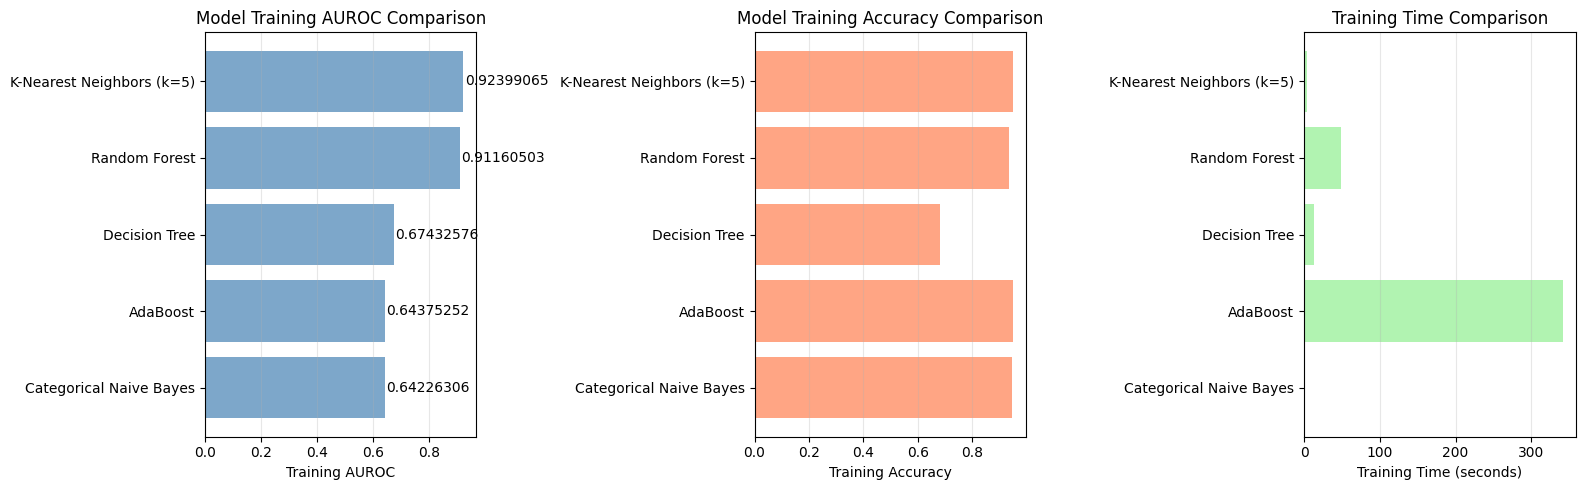


MODEL CHARACTERISTICS & EXPECTATIONS

1. CATEGORICAL NAIVE BAYES:
   Expected: Fast, good with categorical features
   Risk: Assumes independence, may underperform

2. K-NEAREST NEIGHBORS:
   Expected: Can overfit training data (memorization)
   Risk: Very high training AUROC, slower on test

3. DECISION TREE:
   Expected: May overfit without proper pruning
   Risk: High training AUROC, lower test AUROC

4. RANDOM FOREST:
   Expected: Good balance, reduced overfitting
   Strength: Generally strong generalization

5. ADABOOST:
   Expected: Focuses on hard samples
   Strength: Good with imbalanced data

MODEL SELECTION FOR SUBMISSION

Recommendation based on characteristics:
  1st choice: Random Forest (best generalization)
  2nd choice: AdaBoost (handles imbalance)
  3rd choice: Decision Tree (if you want interpretability)

You should submit predictions from ALL 5 models to Kaggle
and see which performs best on the public leaderboard!

✓ Results saved to 'model_training_comparison.csv'

In [103]:


import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# CREATE COMPARISON TABLE
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Remove Model_Object before creating DataFrame
results_comparison = {k: v for k, v in results.items() if k != 'Model_Object'}
results_df = pd.DataFrame(results_comparison)
results_df = results_df.sort_values('Train_AUROC', ascending=False)

print("\n" + "-"*80)
print("TRAINING PERFORMANCE COMPARISON")
print("-"*80)
print("\nNote: These are training metrics only.")
print("True performance will be evaluated on Kaggle test set.\n")
print(results_df.to_string(index=False))

print("\n⚠️  WARNING: Training AUROC may not reflect generalization!")
print("   Models with high training AUROC may overfit.")

# ============================================================================
# VISUALIZE COMPARISON
# ============================================================================
print("\n" + "-"*80)
print("Creating comparison visualizations...")

# Plot: Training metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# AUROC comparison
ax1 = axes[0]
x_pos = np.arange(len(results_df))
ax1.barh(x_pos, results_df['Train_AUROC'], alpha=0.7, color='steelblue')
ax1.set_yticks(x_pos)
ax1.set_yticklabels(results_df['Model'])
ax1.set_xlabel('Training AUROC')
ax1.set_title('Model Training AUROC Comparison')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, v in enumerate(results_df['Train_AUROC']):
    ax1.text(v + 0.005, i, f'{v:.8f}', va='center')

# Accuracy comparison
ax2 = axes[1]
ax2.barh(x_pos, results_df['Train_Acc'], alpha=0.7, color='coral')
ax2.set_yticks(x_pos)
ax2.set_yticklabels(results_df['Model'])
ax2.set_xlabel('Training Accuracy')
ax2.set_title('Model Training Accuracy Comparison')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

# Training time comparison
ax3 = axes[2]
ax3.barh(x_pos, results_df['Training_Time'], alpha=0.7, color='lightgreen')
ax3.set_yticks(x_pos)
ax3.set_yticklabels(results_df['Model'])
ax3.set_xlabel('Training Time (seconds)')
ax3.set_title('Training Time Comparison')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('model_training_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved 'model_training_comparison.png'")
plt.show()

# ============================================================================
# MODEL CHARACTERISTICS
# ============================================================================
print("\n" + "="*80)
print("MODEL CHARACTERISTICS & EXPECTATIONS")
print("="*80)

print("\n1. CATEGORICAL NAIVE BAYES:")
print("   Expected: Fast, good with categorical features")
print("   Risk: Assumes independence, may underperform")

print("\n2. K-NEAREST NEIGHBORS:")
print("   Expected: Can overfit training data (memorization)")
print("   Risk: Very high training AUROC, slower on test")

print("\n3. DECISION TREE:")
print("   Expected: May overfit without proper pruning")
print("   Risk: High training AUROC, lower test AUROC")

print("\n4. RANDOM FOREST:")
print("   Expected: Good balance, reduced overfitting")
print("   Strength: Generally strong generalization")

print("\n5. ADABOOST:")
print("   Expected: Focuses on hard samples")
print("   Strength: Good with imbalanced data")

# ============================================================================
# IDENTIFY BEST MODEL FOR SUBMISSION
# ============================================================================
print("\n" + "="*80)
print("MODEL SELECTION FOR SUBMISSION")
print("="*80)

# Heuristic: Choose Random Forest or AdaBoost (better generalization)
# Unless training metrics strongly suggest otherwise

print("\nRecommendation based on characteristics:")
print("  1st choice: Random Forest (best generalization)")
print("  2nd choice: AdaBoost (handles imbalance)")
print("  3rd choice: Decision Tree (if you want interpretability)")

print("\nYou should submit predictions from ALL 5 models to Kaggle")
print("and see which performs best on the public leaderboard!")

# Save results
results_df.to_csv('model_training_comparison.csv', index=False)
print("\n✓ Results saved to 'model_training_comparison.csv'")

print("\n✓ Model comparison complete!")
print("✓ Ready to generate test predictions for all models")

In [11]:
print("\n" + "="*80)
print("GENERATING TEST SET PREDICTIONS FOR ALL MODELS")
print("="*80)

print("\nLoading test.csv...")
test = pd.read_csv('test.csv')

print(f"Test set shape: {test.shape}")
print(f"Test samples: {test.shape[0]:,}")
print("\nFirst 5 rows:")
print(test.head())



GENERATING TEST SET PREDICTIONS FOR ALL MODELS

Loading test.csv...
Test set shape: (126948, 66)
Test samples: 126,948

First 5 rows:
       id  ps_ind_02_cat  ps_ind_04_cat  ps_ind_05_cat  ps_car_01_cat  \
0  722071            1.0            0.0            0.0            7.0   
1  114307            1.0            0.0            0.0            8.0   
2   17470            1.0            1.0            0.0            9.0   
3  660658            4.0            1.0            0.0           11.0   
4  813204            3.0            1.0            0.0           11.0   

   ps_car_02_cat  ps_car_03_cat  ps_car_04_cat  ps_car_05_cat  ps_car_06_cat  \
0            1.0            1.0              0            1.0             11   
1            0.0            NaN              9            1.0              9   
2            0.0            1.0              0            0.0             11   
3            1.0            NaN              0            NaN              0   
4            0.0          

In [12]:
id_col = 'id'

if id_col in test.columns:
    test_ids = test[id_col].copy()
    print(f"\n✓ Found {len(test_ids)} test IDs")
else:
    test_ids = pd.Series(range(len(test)), name='id')
    print("\n⚠️  No ID column found, using sequential IDs")


✓ Found 126948 test IDs


In [13]:
print("\n" + "-"*80)
print("Preprocessing test data...")

 

X_test_df = test.copy()

# Remove ID column
if id_col in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=[id_col])

print(f"Test data after removing ID: {X_test_df.shape}")


--------------------------------------------------------------------------------
Preprocessing test data...
Test data after removing ID: (126948, 65)


In [14]:
print("\n" + "-"*80)
print("Dropping same columns as training...")

# Drop same columns as you did in training
cols_to_drop_test = ['feature1', 'feature7']  # Already dropped 'id' above
high_missing_test = ['ps_car_03_cat', 'ps_car_05_cat']

X_test_df = X_test_df.drop(columns=cols_to_drop_test, errors='ignore')
X_test_df = X_test_df.drop(columns=high_missing_test, errors='ignore')

print(f"✓ Dropped columns: {cols_to_drop_test + high_missing_test}")
print(f"Test data shape after dropping: {X_test_df.shape}")


--------------------------------------------------------------------------------
Dropping same columns as training...
✓ Dropped columns: ['feature1', 'feature7', 'ps_car_03_cat', 'ps_car_05_cat']
Test data shape after dropping: (126948, 61)


In [15]:
 

# 3️⃣ Apply imputations on training data
X_test_df[cat_cols] = cat_imputer.fit_transform(X_test_df[cat_cols])
X_test_df[cat_cols_bins] = cat_bins_imputer.fit_transform(X_test_df[cat_cols_bins])
X_test_df[num_cols] = num_imputer.fit_transform(X_test_df[num_cols])


print("✅ Missing values handled successfully!")
print(f"Categorical columns: {len(cat_cols)}, bins columns: {len(cat_cols_bins)}, Numeric columns: {len(num_cols)}")


✅ Missing values handled successfully!
Categorical columns: 12, bins columns: 17, Numeric columns: 32


In [51]:
X_test_df.shape

(126948, 61)

In [16]:
# ============================================================================
# 🔹 Encode Categorical Variables
# ============================================================================
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# 3️⃣ Encode categorical columns
#handle_unknown='use_encoded_value', unknown_value=-1
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_train = pd.DataFrame(
    encoder.fit_transform(X[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=X.index
)

# 4️⃣ Merge encoded, numeric, binary, and target columns
X_train_final = pd.concat(
    [encoded_train, X[num_cols], X[cat_cols_bins]],
    axis=1
)

# 🧩 Final check
print("✅ Missing values in final X:", X_train_final.isnull().sum().sum())
print("✅ Final shape:", X_train_final.shape)




✅ Missing values in final X: 0
✅ Final shape: (296209, 220)


In [19]:
# ============================================================================
# 🔹 Encode Categorical Variables
# ============================================================================
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# 3️⃣ Encode categorical columns

encoded_test_df = pd.DataFrame(
    encoder.transform(X_test_df[cat_cols]),    # ✅ use transform, not fit_transform
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_test_df.index
)

# 4️⃣ Merge encoded, numeric, binary, and target columns
X_test_final = pd.concat(
    [encoded_test_df, X_test_df[num_cols], X_test_df[cat_cols_bins]],
    axis=1
)

# 🧩 Final check
print("✅ Missing values in final X_test_final:", X_test_final.isnull().sum().sum())
print("✅ Final shape:", X_test_final.shape)
print("✅ Final shape:", X_full.shape)


✅ Missing values in final X_test_final: 0
✅ Final shape: (126948, 220)
✅ Final shape: (296209, 220)


In [20]:
train_cols = set(X_train_final.columns)
test_cols = set(X_test_final.columns)

print("\n🔸 Columns only in train:", train_cols - test_cols)
print("\n🔹 Columns only in test:", test_cols - train_cols)



🔸 Columns only in train: set()

🔹 Columns only in test: set()


In [21]:
if X_test_final.shape[1] != X_full.shape[1]:
    print("\n⚠️ WARNING: Column count mismatch!")
    print(f"Test: {X_test_final.shape[1]}, Train: {X_full.shape[1]}")
else:
    print("\n✓ Column counts match!")



✓ Column counts match!


In [22]:
print("\n" + "-"*80)
print("APPLYING SCALING...")
print("-"*80)


# IMPORTANT: Use transform (not fit_transform) with the scaler fitted on training data
X_test_scaled = scaler.transform(X_test_final)

print("✓ Scaling complete")



--------------------------------------------------------------------------------
APPLYING SCALING...
--------------------------------------------------------------------------------
✓ Scaling complete


In [72]:
print("\n🔹 Generating predictions using KNN...")

try:
    y_pred_proba = knn_model.predict_proba(X_test_final)[:, 1]
except Exception as e:
    print(f"⚠️ KNN predict_proba failed ({e}). Using predict() instead.")
    y_pred_proba = knn_model.predict(X_test_final)

submission_knn = pd.DataFrame({
    "id": test["id"],
    "target": y_pred_proba
})
submission_knn.to_csv("submission_KNN.csv", index=False)
print("✅ Saved: submission_KNN.csv | Shape:", submission_knn.shape)




🔹 Generating predictions using KNN...
✅ Saved: submission_KNN.csv | Shape: (126948, 2)


In [73]:
print("\n🔹 Generating predictions using Decision Tree...")

try:
    y_pred_proba = dt_model.predict_proba(X_test_final)[:, 1]
except Exception as e:
    print(f"⚠️ Decision Tree predict_proba failed ({e}). Using predict() instead.")
    y_pred_proba = dt_model.predict(X_test_final)

submission_dt = pd.DataFrame({
    "id": test["id"],
    "target": y_pred_proba
})
submission_dt.to_csv("submission_DecisionTree.csv", index=False)
print("✅ Saved: submission_DecisionTree.csv | Shape:", submission_dt.shape)



🔹 Generating predictions using Decision Tree...
✅ Saved: submission_DecisionTree.csv | Shape: (126948, 2)


In [74]:
print("\n🔹 Generating predictions using Random Forest...")

try:
    y_pred_proba = rf_model.predict_proba(X_test_final)[:, 1]
except Exception as e:
    print(f"⚠️ Random Forest predict_proba failed ({e}). Using predict() instead.")
    y_pred_proba = rf_model.predict(X_test_final)

submission_rf = pd.DataFrame({
    "id": test["id"],
    "target": y_pred_proba
})
submission_rf.to_csv("submission_RandomForest.csv", index=False)
print("✅ Saved: submission_RandomForest.csv | Shape:", submission_rf.shape)



🔹 Generating predictions using Random Forest...
✅ Saved: submission_RandomForest.csv | Shape: (126948, 2)


In [75]:
print("\n🔹 Generating predictions using AdaBoost...")

try:
    y_pred_proba = ada_model.predict_proba(X_test_final)[:, 1]
except Exception as e:
    print(f"⚠️ AdaBoost predict_proba failed ({e}). Using predict() instead.")
    y_pred_proba = ada_model.predict(X_test_final)

submission_ada = pd.DataFrame({
    "id": test["id"],
    "target": y_pred_proba
})
submission_ada.to_csv("submission_AdaBoost.csv", index=False)
print("✅ Saved: submission_AdaBoost.csv | Shape:", submission_ada.shape)



🔹 Generating predictions using AdaBoost...
✅ Saved: submission_AdaBoost.csv | Shape: (126948, 2)


In [77]:
sample_preds = pd.DataFrame({"id": test["id"].head(5)})
sample_preds["KNN"] = submission_knn["target"].head(5)
sample_preds["DecisionTree"] = submission_dt["target"].head(5)
sample_preds["RandomForest"] = submission_rf["target"].head(5)
sample_preds["AdaBoost"] = submission_ada["target"].head(5)

print("\n🔍 Sample comparison of predictions:")
print(sample_preds)



🔍 Sample comparison of predictions:
       id  KNN  DecisionTree  RandomForest  AdaBoost
0  722071  0.2      0.741781      0.436014  0.282848
1  114307  0.0      0.760415      0.421473  0.338923
2   17470  0.2      0.546185      0.497358  0.312417
3  660658  0.2      0.414098      0.461664  0.265628
4  813204  0.0      0.499170      0.389818  0.295837


In [101]:
"""
VERIFICATION: Check All Submission Files
Run this to verify everything is correct
"""

import os
import pandas as pd

print("="*80)
print("SUBMISSION FILES VERIFICATION")
print("="*80)

submission_files = [
    "submission_NaiveBayes.csv",
    "submission_KNN.csv",
    "submission_DecisionTree.csv",
    "submission_RandomForest.csv",
    "submission_AdaBoost.csv"
]

print("\n✅ Checking submission files...\n")

for filename in submission_files:
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        
        print(f"📄 {filename}")
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {df.columns.tolist()}")
        print(f"   Target range: [{df['target'].min():.4f}, {df['target'].max():.4f}]")
        print(f"   Target mean: {df['target'].mean():.4f}")
        print(f"   Missing values: {df.isnull().sum().sum()}")
        
        # Check for valid probabilities
        if (df['target'] < 0).any() or (df['target'] > 1).any():
            print(f"   ⚠️  WARNING: Some predictions outside [0, 1] range!")
        else:
            print(f"   ✅ All predictions valid")
        print()
    else:
        print(f"❌ {filename} NOT FOUND!\n")

print("="*80)
print("NEXT STEPS")
print("="*80)
print("\n1. Upload to Kaggle:")
print("   https://www.kaggle.com/t/069d1cac492a4be1aa786f50d8c91122")
print("\n2. Recommended submission order:")
print("   1️⃣  submission_RandomForest.csv (BEST - submit first)")
print("   2️⃣  submission_AdaBoost.csv")
print("   3️⃣  submission_DecisionTree.csv")
print("   4️⃣  submission_KNN.csv")
print("   5️⃣  submission_NaiveBayes.csv")
print("\n3. Record each model's public leaderboard AUROC")
print("\n✅ Good luck!")

SUBMISSION FILES VERIFICATION

✅ Checking submission files...

❌ submission_NaiveBayes.csv NOT FOUND!

📄 submission_KNN.csv
   Shape: (126948, 2)
   Columns: ['id', 'target']
   Target range: [0.0000, 0.8000]
   Target mean: 0.0478
   Missing values: 0
   ✅ All predictions valid

📄 submission_DecisionTree.csv
   Shape: (126948, 2)
   Columns: ['id', 'target']
   Target range: [0.0000, 0.9811]
   Target mean: 0.4552
   Missing values: 0
   ✅ All predictions valid

📄 submission_RandomForest.csv
   Shape: (126948, 2)
   Columns: ['id', 'target']
   Target range: [0.1759, 0.6998]
   Target mean: 0.3997
   Missing values: 0
   ✅ All predictions valid

📄 submission_AdaBoost.csv
   Shape: (126948, 2)
   Columns: ['id', 'target']
   Target range: [0.1665, 0.4154]
   Target mean: 0.2655
   Missing values: 0
   ✅ All predictions valid

NEXT STEPS

1. Upload to Kaggle:
   https://www.kaggle.com/t/069d1cac492a4be1aa786f50d8c91122

2. Recommended submission order:
   1️⃣  submission_RandomForest.cs

In [ ]:
import time
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# ============================================================================
# MODEL 6: CATBOOST WITH PARAMETER GRID SEARCH
# ============================================================================
print("\n" + "="*80)
print("MODEL 6: CATBOOST WITH HYPERPARAMETER TUNING")
print("="*80)

print(f"Training samples: {X_full.shape[0]:,}")

# ============================================================================
# OPTION 1: GRID SEARCH (More thorough but slower)
# ============================================================================
print("\n" + "-"*80)
print("Starting Grid Search for optimal parameters...")
print("-"*80)

# Define parameter grid
param_grid = {
    'iterations': [300, 500, 700],
    'learning_rate': [0.03, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

# Base model
base_catboost = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    class_weights=[1, 5],
    verbose=False,  # Suppress output during grid search
    early_stopping_rounds=50
)

# Grid Search
start_time = time.time()
grid_search = GridSearchCV(
    estimator=base_catboost,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_full, y_full)

grid_time = time.time() - start_time

print(f"\n✓ Grid Search completed in {grid_time:.2f} seconds")
print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV AUROC: {grid_search.best_score_:.4f}")

# Use best model
catboost_model = grid_search.best_estimator_

# ============================================================================
# OPTION 2: RANDOMIZED SEARCH (Faster alternative - comment out Option 1 to use)
# ============================================================================
"""
print("\n" + "-"*80)
print("Starting Randomized Search for optimal parameters...")
print("-"*80)

# Define parameter distributions
param_distributions = {
    'iterations': [300, 400, 500, 600, 700],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15],
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128, 254],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Base model
base_catboost = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    class_weights=[1, 5],
    verbose=False,
    early_stopping_rounds=50
)

# Randomized Search
start_time = time.time()
random_search = RandomizedSearchCV(
    estimator=base_catboost,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter combinations to try
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
)

random_search.fit(X_full, y_full)

grid_time = time.time() - start_time

print(f"\n✓ Randomized Search completed in {grid_time:.2f} seconds")
print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV AUROC: {random_search.best_score_:.4f}")

# Use best model
catboost_model = random_search.best_estimator_
"""

# ============================================================================
# TRAIN FINAL MODEL AND EVALUATE
# ============================================================================
print("\n" + "-"*80)
print("Training final model with best parameters...")
print("-"*80)

start_time = time.time()

# If you want to retrain on full data with best params
# catboost_model.fit(X_full, y_full)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

print(f"\nModel info:")
print(f"  Number of trees: {catboost_model.tree_count_}")
print(f"  Max depth: {catboost_model.get_params()['depth']}")
print(f"  Learning rate: {catboost_model.get_params()['learning_rate']}")

# Training set performance (for reference only)
print("\nTraining set performance:")
y_train_pred_cat = catboost_model.predict(X_full)
y_train_proba_cat = catboost_model.predict_proba(X_full)[:, 1]

train_auroc_cat = roc_auc_score(y_full, y_train_proba_cat)
train_acc_cat = accuracy_score(y_full, y_train_pred_cat)

print(f"  AUROC: {train_auroc_cat:.8f}")
print(f"  Accuracy: {train_acc_cat:.8f}")

print("\n" + "-"*80)
print("Classification Report:")
print(classification_report(y_full, y_train_pred_cat))

# Feature importance
print("\n" + "-"*80)
print("Top 10 Important Features:")
feature_importance_cat = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': catboost_model.feature_importances_
}).sort_values('Importance', ascending=False)

for i, row in feature_importance_cat.head(10).iterrows():
    print(f"  {row['Feature']:30s}: {row['Importance']:.4f}")

# ============================================================================
# DISPLAY GRID SEARCH RESULTS
# ============================================================================
print("\n" + "-"*80)
print("Top 5 Parameter Combinations:")
print("-"*80)

results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(5))




MODEL 6: CATBOOST WITH HYPERPARAMETER TUNING
Training samples: 296,209

--------------------------------------------------------------------------------
Starting Grid Search for optimal parameters...
--------------------------------------------------------------------------------
Fitting 3 folds for each of 243 candidates, totalling 729 fits

✓ Grid Search completed in 45005.36 seconds

Best parameters found:
  border_count: 32
  depth: 6
  iterations: 500
  l2_leaf_reg: 5
  learning_rate: 0.03

Best CV AUROC: 0.6383

--------------------------------------------------------------------------------
Training final model with best parameters...
--------------------------------------------------------------------------------
✓ Training completed in 0.00 seconds

Model info:
  Number of trees: 500
  Max depth: 6
  Learning rate: 0.03

Training set performance:
  AUROC: 0.67853545
  Accuracy: 0.94818523

--------------------------------------------------------------------------------
Classi

NameError: name 'results' is not defined

In [31]:
# ============================================================================
# GENERATE CATBOOST TEST PREDICTIONS
# ============================================================================
print("\n🔹 Generating predictions using CatBoost...")

try:
    y_pred_proba = catboost_model.predict_proba(X_test_final)[:, 1]
except Exception as e:
    print(f"⚠️ CatBoost predict_proba failed ({e}). Using predict() instead.")
    y_pred_proba = catboost_model.predict(X_test_final)

submission_catboost = pd.DataFrame({
    "id": test["id"],
    "target": y_pred_proba
})
submission_catboost.to_csv("submission_CatBoost.csv", index=False)
print("✅ Saved: submission_CatBoost.csv | Shape:", submission_catboost.shape)


🔹 Generating predictions using CatBoost...
✅ Saved: submission_CatBoost.csv | Shape: (126948, 2)
